# Add attributes to GNSS data

Using the pandas series, i add attributes to the data, e.g. velocity, for analysis

Using this i take a first look at speed up events

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
from numpy import linalg as LA
from functools import reduce
import os
import sys
import time
import datetime 
import pandas as pd
import geopandas as gpd

from geopandas import GeoDataFrame
from shapely.geometry import Point
import fiona

sys.path.append(os.path.abspath('/Users/home/whitefar/DATA/code/'))
os.chdir("/Users/home/whitefar/DATA/TASMAN/ABSOLUTE/")

In [2]:
#with only the site_units that have data over the time period
site_units = [['tal1', 'arc2'], ['tal2', 'arc1'], ['tac2', 'arc5'], ['tac3', 'arc4'], ['tar2', 'arc6']] #these are the ones with data

dfs = {}  #dataframes

for site, unit in site_units:
    dfs[site+unit] = pd.read_csv(f"/Volumes/arc_02/whitefar/DATA/TASMAN/GNSS_ABSOLUTE/{site}{unit}_may1-18_2016.csv",index_col=0)

In [3]:
dfs.keys()

dict_keys(['tal1arc2', 'tal2arc1', 'tac2arc5', 'tac3arc4', 'tar2arc6'])

## Add distance, velocity

In [11]:
for df in dfs:
    
    dfs[df]["Points"] = [Point(xy) for xy in zip(dfs[df].Latitude, dfs[df].Longitude)]
    
    distance_from_prev = [Point.distance(dfs[df].Points[i]) for i,Point in enumerate(dfs[df].Points[1:])] #note the 1:, equivalent to i+1
    distance_from_prev.insert(0,0)

    dfs[df]["distance"] =pd.Series( distance_from_prev)

    dfs[df]["cumulative_distance"] = dfs[df].distance.cumsum()
    
    dfs[df]["datetime"] = pd.Series([datetime.datetime.fromtimestamp(timestamp) for timestamp in dfs[df].Timestamp])
    
    dfs[df]["dt"] = dfs[df]["Timestamp"].diff()
    
    dfs[df]["velocity"] = [d/dfs[df].dt[i] for i,d in enumerate(dfs[df].distance)]
    
    dfs[df].to_csv(f"/Volumes/arc_02/whitefar/DATA/TASMAN/GNSS_ABSOLUTE/GNSS_dataframe/{df}_moreattributes.csv")

In [5]:
dfs['tal1arc2']["Points"]

0              POINT (-43.648039569 170.20091327)
1             POINT (-43.648039386 170.200913297)
2             POINT (-43.648039422 170.200913215)
3             POINT (-43.648039462 170.200913311)
4             POINT (-43.648039426 170.200913323)
                           ...                   
43801         POINT (-43.648073208 170.200898615)
43802    POINT (-43.64807324100001 170.200898541)
43803         POINT (-43.648073247 170.200898609)
43804         POINT (-43.648073158 170.200898619)
43805    POINT (-43.64807323100001 170.200898615)
Name: Points, Length: 43806, dtype: object

In [ ]:
# crs = {'init': 'epsg:4326'} 
# #make a geodataseries
# for df in dfs:
        
#     dfs[df] = GeoDataFrame(dfs[df], crs=crs, geometry="Points")  

In [10]:
dfs[df]["Points"]

0        POINT (-43.632093042 170.194638315)
1        POINT (-43.632093282 170.194638093)
2        POINT (-43.632093829 170.194637399)
3        POINT (-43.632093709 170.194637575)
4        POINT (-43.632093506 170.194637665)
                        ...                 
47162    POINT (-43.632120504 170.194627951)
47163    POINT (-43.632120533 170.194627928)
47164    POINT (-43.632120463 170.194627897)
47165    POINT (-43.632120378 170.194627985)
47166    POINT (-43.632120328 170.194627901)
Name: Points, Length: 47167, dtype: object

0        POINT (-43.632093042 170.194638315)
1        POINT (-43.632093282 170.194638093)
2        POINT (-43.632093829 170.194637399)
3        POINT (-43.632093709 170.194637575)
4        POINT (-43.632093506 170.194637665)
                        ...                 
47162    POINT (-43.632120504 170.194627951)
47163    POINT (-43.632120533 170.194627928)
47164    POINT (-43.632120463 170.194627897)
47165    POINT (-43.632120378 170.194627985)
47166    POINT (-43.632120328 170.194627901)
Name: Points, Length: 47167, dtype: object

In [ ]:
# crs = {'init': 'epsg:4326'} 

# #make a geodataseries
# for df in dfs:
    
#     dfs[df] = GeoDataFrame(dfs[df], crs=crs, geometry=geometry)  
    
#     dfs[df].to_file(f"/Volumes/arc_02/whitefar/DATA/TASMAN/GNSS_ABSOLUTE/{df}_moreattributes.shp")
     
#     dfs[df] = dfs[df].rename(columns={'geometry': 'Points'})

/Users/home/whitefar/software/miniconda3/envs/arran_gis/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


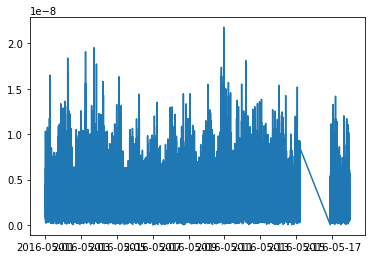

In [17]:
plt.plot(dfs['tal1arc2'].datetime,dfs['tal1arc2'].velocity)

In [51]:
dfs['tal1arc2'].columns

Index(['Timestamp', 'site', 'unit', 'Year', 'DOY', 'Seconds', 'Latitude',
       'Longitude', 'Height', 'SigN', 'SigE', 'SigH', 'RMS', 'DDiff', 'Atm',
       '+-', 'Fract', 'DOY.1', 'Epoch', '#BF', 'NotF', 'Points', 'distance',
       'cumulative_distance', 'datetime', 'dt', 'velocity'],
      dtype='object')

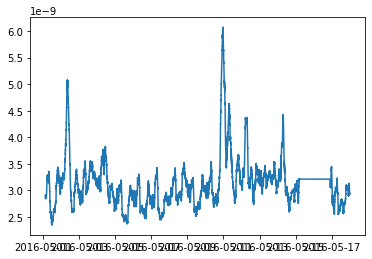

In [47]:
plt.plot(dfs['tal1arc2'].datetime,dfs['tal1arc2'].velocity.rolling(window=400).mean())

In [48]:
peak3 = np.argmax(dfs['tal1arc2'].velocity.rolling(window=300).mean().to_numpy()[300:])
peak2 = np.argmax(dfs['tal1arc2'].velocity.rolling(window=200).mean().to_numpy()[200:])
peak1 = np.argmax(dfs['tal1arc2'].velocity.rolling(window=100).mean().to_numpy()[100:])
peak0 = np.argmax(dfs['tal1arc2'].velocity.rolling(window=10).mean().to_numpy()[10:])
print(peak0,peak1,peak2,peak3)
print(dfs['tal1arc2'].datetime[peak1])

28666 28612 28250 28233
2016-05-10 22:30:30


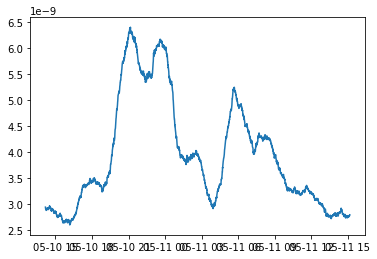

In [49]:
f = peak1-1000
t = peak1 + 2000
plt.plot(dfs['tal1arc2'].datetime[f:t],dfs['tal1arc2'].velocity.rolling(window=200).mean()[f:t])

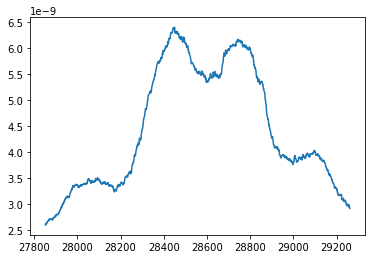

In [71]:
f = peak1-760
t = peak1 + 650
plt.plot(dfs['tal1arc2'].velocity.rolling(window=200).mean()[f:t])

# Find speedup events

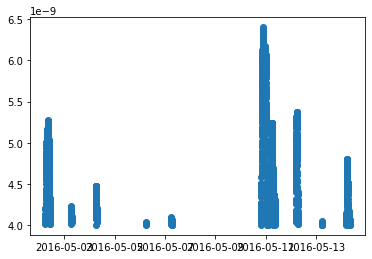

In [119]:
event_indicies = np.argwhere(dfs['tal1arc2'].velocity.rolling(window=200).mean() > 4e-9).flatten()
plt.plot(dfs['tal1arc2'].datetime[event_indicies],dfs['tal1arc2'].velocity.rolling(window=200).mean()[event_indicies],'o')

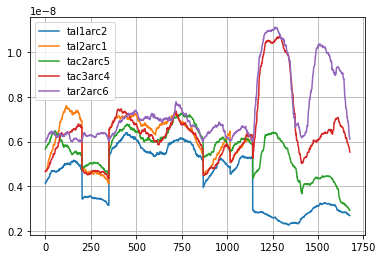

In [160]:
for df in dfs.keys():
    plt.plot(np.arange(len(event_indicies)),dfs[df].velocity.rolling(window=200).mean()[event_indicies])
plt.grid()
plt.legend(dfs.keys())
plt.show()

/Users/home/whitefar/software/miniconda3/envs/arran_gis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


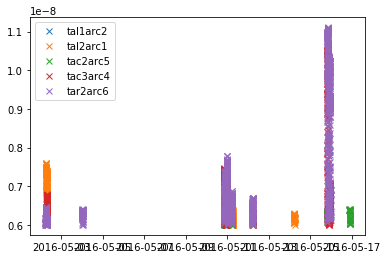

In [161]:
for df in dfs.keys():
    event_indicies = np.argwhere(dfs[df].velocity.rolling(window=200).mean() > 6e-9).flatten()
    plt.plot(dfs[df].datetime[event_indicies],dfs[df].velocity.rolling(window=200).mean()[event_indicies],'x')
plt.legend(dfs.keys())
plt.show()

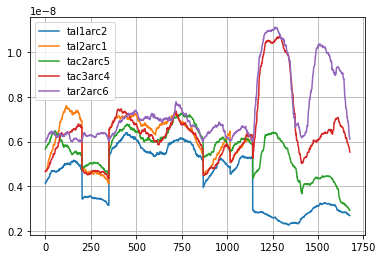

In [162]:
for df in dfs.keys():
    plt.plot(np.arange(len(event_indicies)),dfs[df].velocity.rolling(window=200).mean()[event_indicies])
plt.grid()
plt.legend(dfs.keys())
plt.show()

In [166]:
event_dates = dfs['tac3arc4'].datetime[event_indicies].dt.date.drop_duplicates()

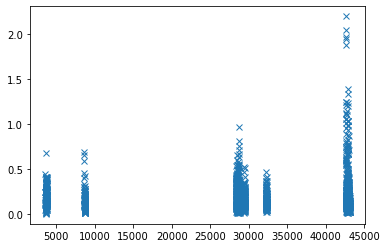

In [176]:
plt.plot(dfs['tar2arc6'].velocity[event_indicies]*60*60*24*365.25,'x')